In [164]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_theme()


In [165]:
native_df = pd.read_csv(Path(Path.home(), "Documents/xray/dev/29_synthetic_native_3/data/scores/7mhf_30.csv"))
native_df["xray_0+xray_1"] = native_df["xray_0"] + native_df["xray_1"]
native_df["rmsd_0+rmsd_1"] = (native_df["rmsd_0"] + native_df["rmsd_1"])/2
native_df.head()

,Unnamed: 0,pdb,w_0_0,w_1_0,w_0_1,w_1_1,xray_0,r_free_0,rmsd_0,ff,xray_1,r_free_1,rmsd_1,xray_0+xray_1,rmsd_0+rmsd_1
0,0,/wynton/group/sali/mhancock/xray/sample_bench/...,0.510588,0.489412,0.555566,0.444434,4.025633,0.039276,0.0,21250.054492,4.053322,0.043427,0.0,8.078955,0.0
1,1,/wynton/group/sali/mhancock/xray/sample_bench/...,0.893325,0.106675,0.739213,0.260787,4.227168,0.040899,0.0,20682.124765,4.121057,0.041334,0.0,8.348225,0.0
2,2,/wynton/group/sali/mhancock/xray/sample_bench/...,0.585996,0.414004,0.582210,0.417790,4.054030,0.040999,0.0,20822.373139,4.048832,0.040720,0.0,8.102862,0.0
3,3,/wynton/group/sali/mhancock/xray/sample_bench/...,0.375460,0.624540,0.297137,0.702863,4.064986,0.041624,0.0,21136.167610,4.103359,0.040295,0.0,8.168346,0.0
4,4,/wynton/group/sali/mhancock/xray/sample_bench/...,0.303720,0.696280,0.357188,0.642812,4.093771,0.041402,0.0,20683.275695,4.082613,0.040715,0.0,8.176383,0.0


In [166]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def fp(x,L,k,x0):
    return (L * k * np.exp(-k * (x - x0))) / (1 + np.exp(-k * (x - x0)))**2

def fdp(x,L,k,x0):
    return (L * k**2 * np.exp(-2*k * (x - x0)) * (-np.exp(k * (x - x0)) + 1)) / (1 + np.exp(-k * (x - x0)))**3

[12.55177374  4.53541733 -0.08559144]


[]

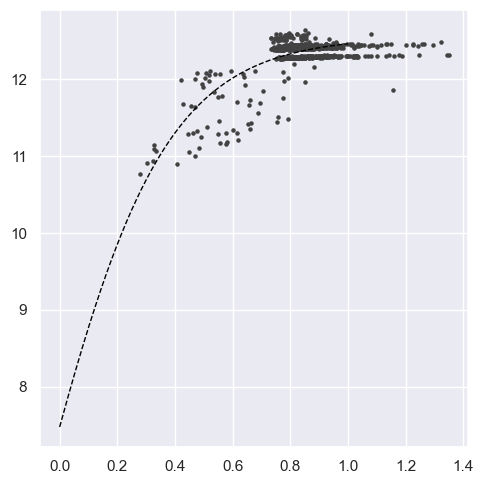

In [182]:
# Test the fit for one score df

score_df = pd.read_csv(Path(Path.home(), "Documents/xray/score_bench/data/7mhf/155_native_N4_decoys/rand1000_0.csv"))
score_df["xray_0+xray_1"] = score_df["xray_0"] + score_df["xray_1"]
score_df["rmsd_0+rmsd_1"] = (score_df["rmsd_0"] + score_df["rmsd_1"])/2
score_df.head()

xs = score_df[(score_df["rmsd_0"] < 1) & (score_df["rmsd_0"] > .01)]["rmsd_0+rmsd_1"]
ys = score_df[(score_df["rmsd_0"] < 1) & (score_df["rmsd_0"] > .01)]["xray_0+xray_1"]
# param_est = [6.44497246, 10.39341181, 0.07460433]
param_est = [12, 10.8636, 0.06799455]

# xs = score_df["rmsd_0+rmsd_1"]
# ys = score_df["xray_0+xray_1"]

params, covariance = curve_fit(logistic_func, xs,ys, param_est, maxfev=10000)
L_fit, k_fit, x0_fit = params
print(params)

fig, ax = plt.subplots(1, 1, figsize=(5,5), tight_layout=True)
ax.scatter(score_df["rmsd_0+rmsd_1"], score_df["xray_0+xray_1"], c="#424242ff", s=5)
# ax.scatter(native_df["rmsd_0"], native_df["xray_0"], c="#424242ff", s=5)

linespace = [0 + x*(1)/1000 for x in range(1000)]
ax.plot(linespace, [logistic_func(x, L_fit, k_fit, x0_fit) for x in linespace], c="black", linewidth=1, linestyle="dashed")
ax.plot()



In [169]:
def get_var(score_df, score_field, rmsd_field, L_fit, k_fit, x0_fit):
    var = 0
    for i in range(len(score_df)):
        decoy_rmsd = score_df.iloc[i][rmsd_field]
        var = var + (logistic_func(decoy_rmsd, L_fit, k_fit, x0_fit) - score_df.iloc[i][score_field])**2

    var = var / (len(score_df)-1)
    return var

In [202]:
def get_first_fp_zero(L, k, x0):
    linespace = [x/200 for x in range(1000)]
    first_fp_zero = 0
    fp_vals = [fp(x, L, k, x0) for x in linespace]
    for i in range(len(fp_vals)):
        fp_val = fp_vals[i]
        if fp_val <= .05:
            first_fp_zero = linespace[i]
            break

    return first_fp_zero

get_first_fp_zero(L_fit, k_fit, x0_fit)

1.265

In [203]:
dir_name_arr = np.array(["122_native_decoys_1_state", "121_native_decoys", "155_native_N4_decoys"])
score_df_arr = np.ndarray(shape=(3,2,10),dtype=pd.DataFrame)
params_arr = np.ndarray(shape=(3,2,10),dtype=tuple)
radius_of_conv_arr = np.ndarray(shape=(3,2,10),dtype=float)
spread_arr = np.ndarray(shape=(3,2,10),dtype=float)

params_dict = dict()
for i in range(3):
    for j in range(2):
        if j == 1:
            score_field, rmsd_field = "xray_0+xray_1", "rmsd_0+rmsd_1"
            param_est = [12.55177374, 4.53541733, -0.08559144]
        else:
            score_field, rmsd_field = "xray_0", "rmsd_0"
            param_est = [6.44497246, 10.39341181, 0.07460433]

        first_fp_zeros, spreads = list(), list()
        for k in range(10):
            score_df = pd.read_csv(Path(Path.home(), "Documents/xray/score_bench/data/7mhf/{}/rand1000_{}.csv".format(dir_name_arr[i], k)))
            score_df["xray_0+xray_1"] = score_df["xray_0"] + score_df["xray_1"]
            score_df["rmsd_0+rmsd_1"] = (score_df["rmsd_0"] + score_df["rmsd_1"])/2

            # Filter based on RMSD
            score_df = score_df[(score_df[rmsd_field] < 1) & (score_df[rmsd_field] > .01)]
            score_df_arr[i,j,k] = score_df

            xs = score_df[rmsd_field]
            ys = score_df[score_field]
            params, covariance = curve_fit(logistic_func, xs, ys, param_est, maxfev=10000)
            L_fit, k_fit, x0_fit = params[0], params[1], params[2]
            params_arr[i,j,k] = L_fit, k_fit, x0_fit

            radius_of_conv_arr[i,j,k] = get_first_fp_zero(L_fit, k_fit, x0_fit)
            spread_arr[i,j,k] = get_var(score_df, score_field, rmsd_field, L_fit, k_fit, x0_fit)

        # print(job, score_field, rmsd_field)
        # print(np.mean(first_fp_zeros), np.std(first_fp_zeros))
        # print(np.mean(spreads), np.std(spreads))


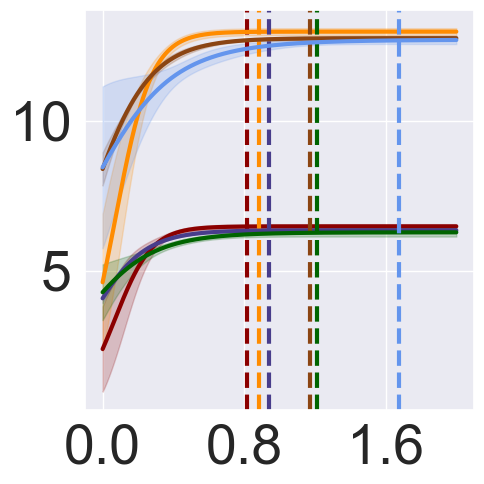

In [235]:
# Plot the radius of convergence
fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)
ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

x = np.linspace(0, 2, 1000)

colors = [mcolors.CSS4_COLORS["darkred"], mcolors.CSS4_COLORS["darkorange"], mcolors.CSS4_COLORS["darkslateblue"], mcolors.CSS4_COLORS["saddlebrown"], mcolors.CSS4_COLORS["darkgreen"], mcolors.CSS4_COLORS["cornflowerblue"]]

for i in range(3):
    for j in range(2):
        y_avgs, y_std = list(), list()
        for l in range(len(linespace)):
            ys = list()
            for k in range(10):
                L_fit, k_fit, x0_fit = params_arr[i,j,k]
                ys.append(logistic_func(x[l], L_fit, k_fit, x0_fit))

            y_avgs.append(np.mean(ys))
            y_std.append(np.std(ys)+np.std(ys))

        color = colors[i*2+j]
        plt.plot(x, y_avgs, linewidth=3, color=color)
        plt.fill_between(x, np.array(y_avgs) - np.array(y_std), np.array(y_avgs) + np.array(y_std), alpha=0.2, color=color)
        plt.axvline(x=np.mean(radius_of_conv_arr[i,j]), linestyle='--', linewidth=3, alpha=1, color=color)


plt.savefig(Path(Path.home(), "Desktop/radius_of_convergence.png"))


            # linespace = [0 + x*(1)/1000 for x in range(1000)]
            # plt.plot(linespace, [logistic_func(x, L_fit, k_fit, x0_fit) for x in linespace], c="black", linewidth=1, linestyle="dashed")



In [205]:
params_arr[0,0]

array([(6.444852885734404, 10.41744611542521, 0.0752504984805649),
       (6.545226713469565, 7.513045293874988, -0.007781629254092067),
       (6.452642613538452, 7.768008277794067, -0.01581394093951454),
       (6.451380640479831, 12.401801670344758, 0.14347800793794066),
       (6.4912915689270285, 9.093425245139256, 0.0373165524013553),
       (6.533053204955092, 10.013056094046494, 0.07432222002456162),
       (6.451232923392901, 10.17165211633349, 0.08778162938880477),
       (6.472021224620571, 9.441180372617328, 0.06318999271084291),
       (6.4551150727064055, 8.584324893358408, 0.02355291947879091),
       (6.523891658917268, 9.860473373496347, 0.053310869659654335)],
      dtype=object)

### Plot all

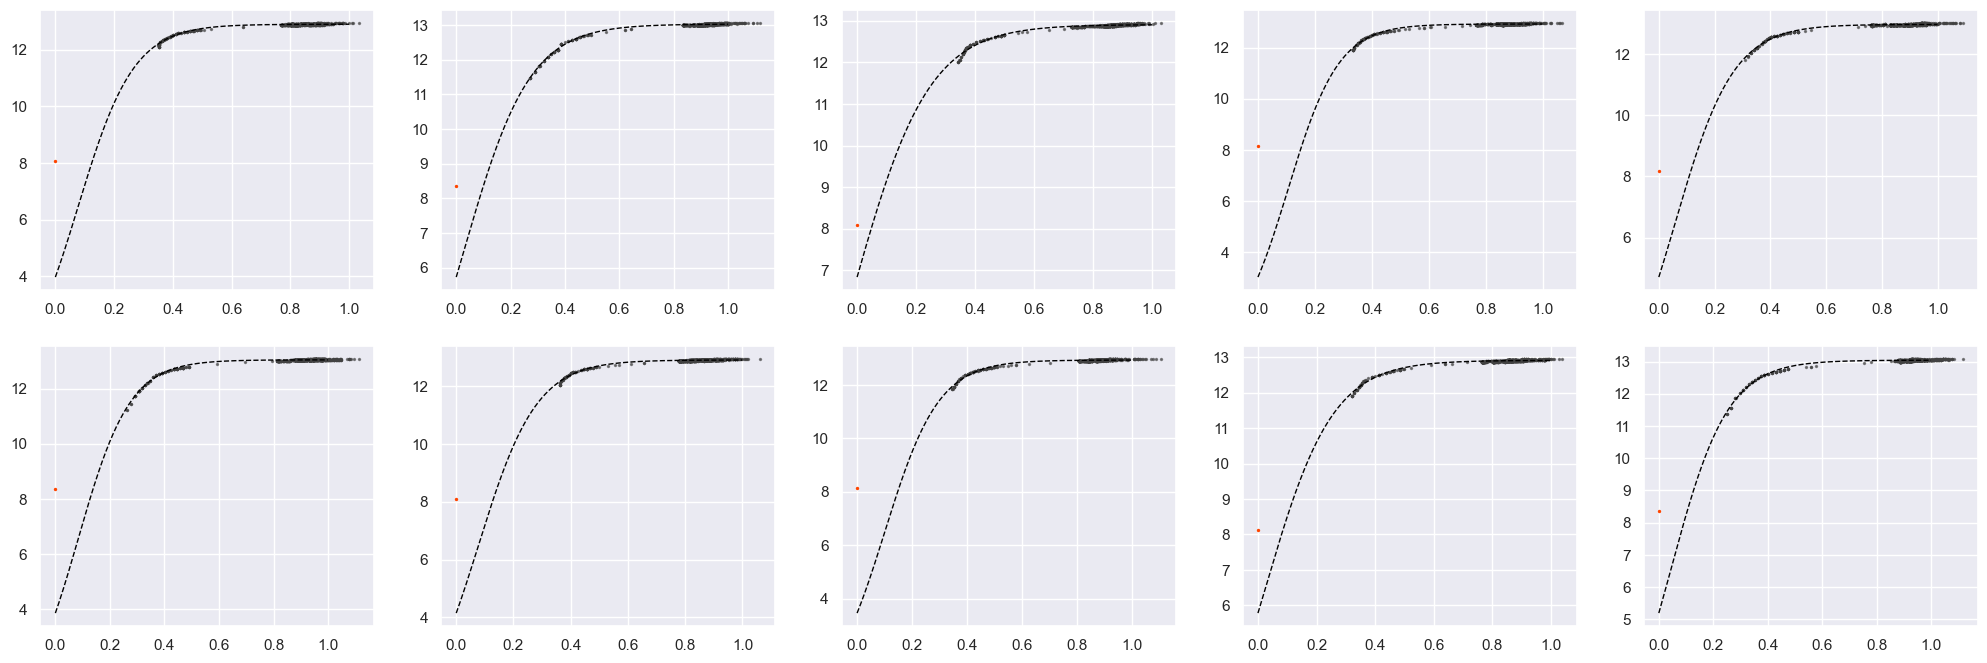

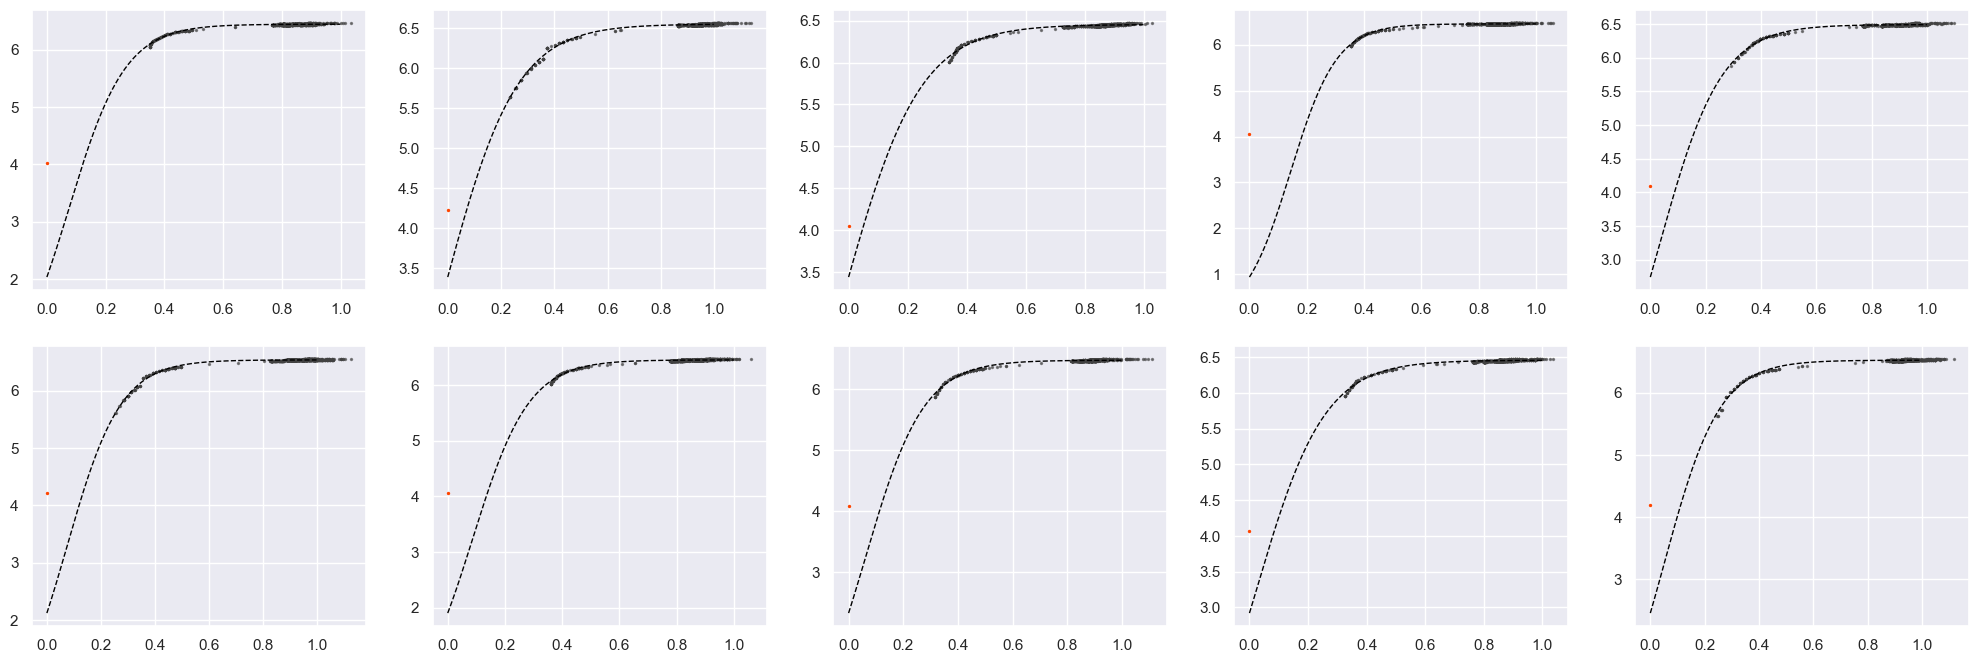

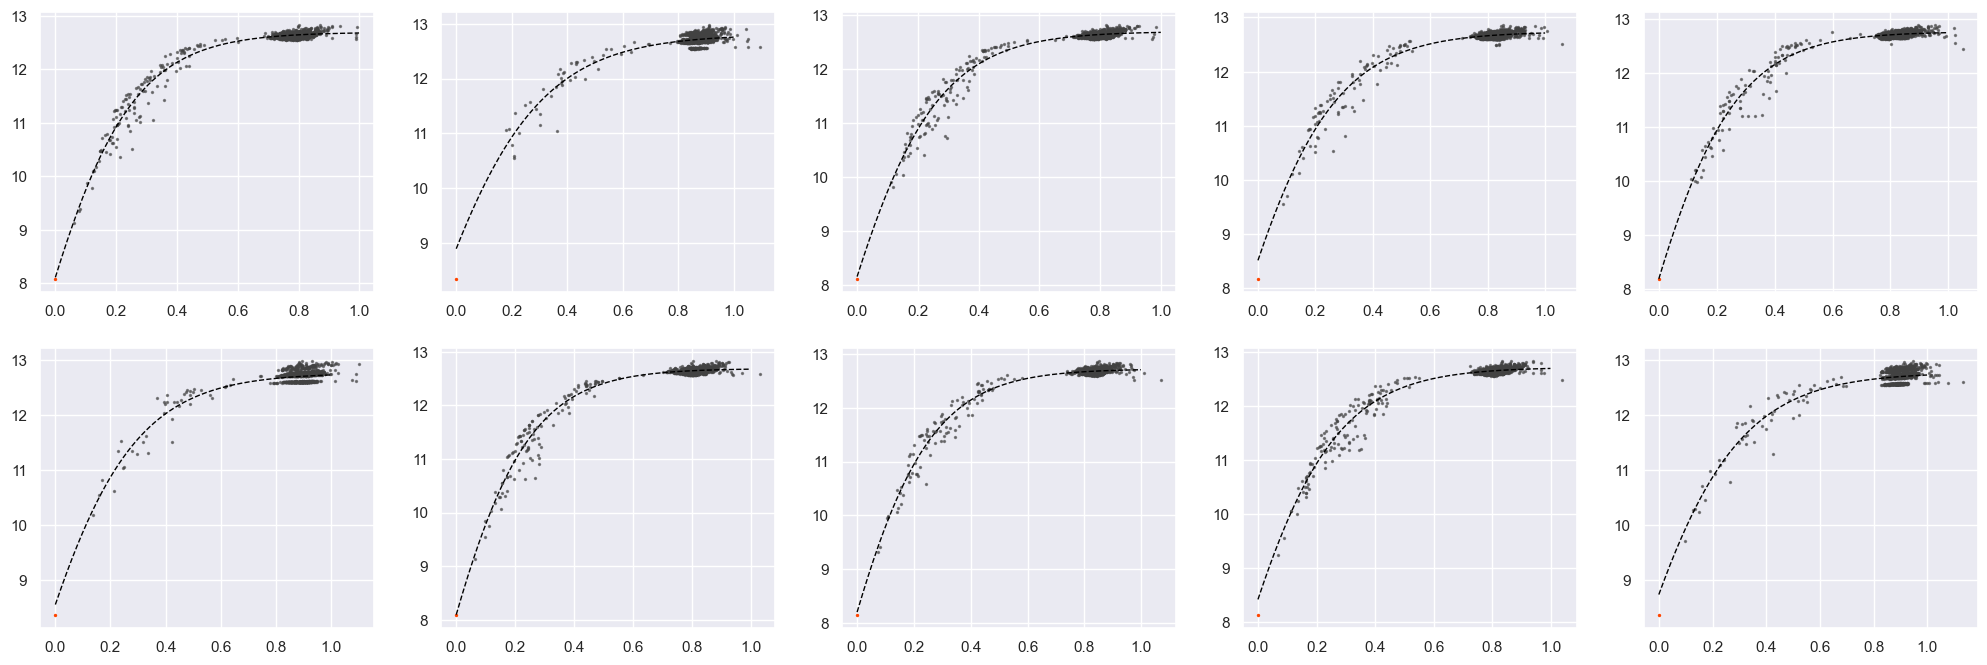

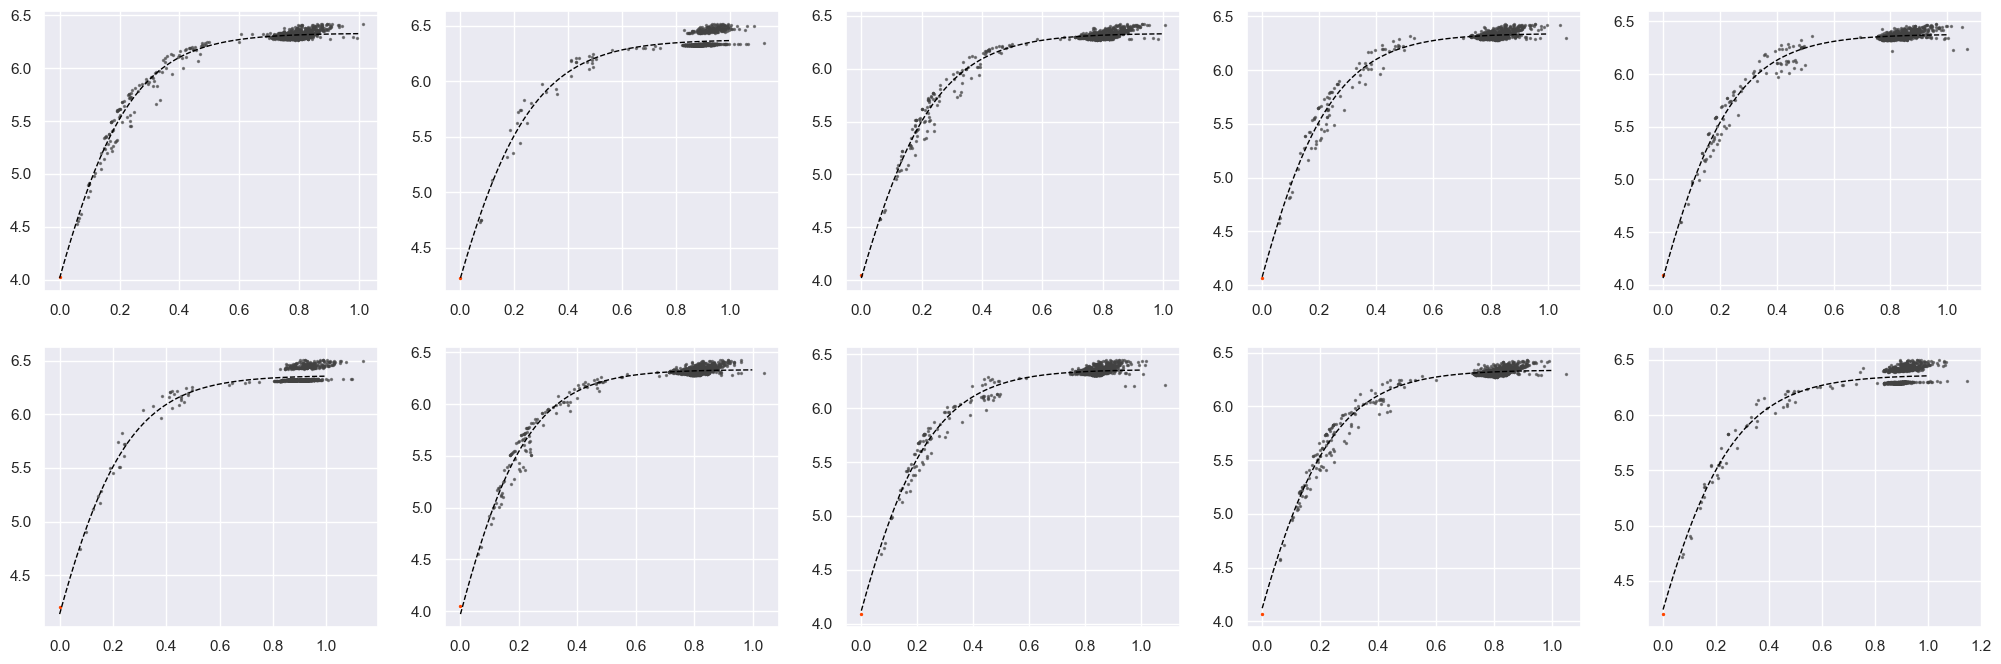

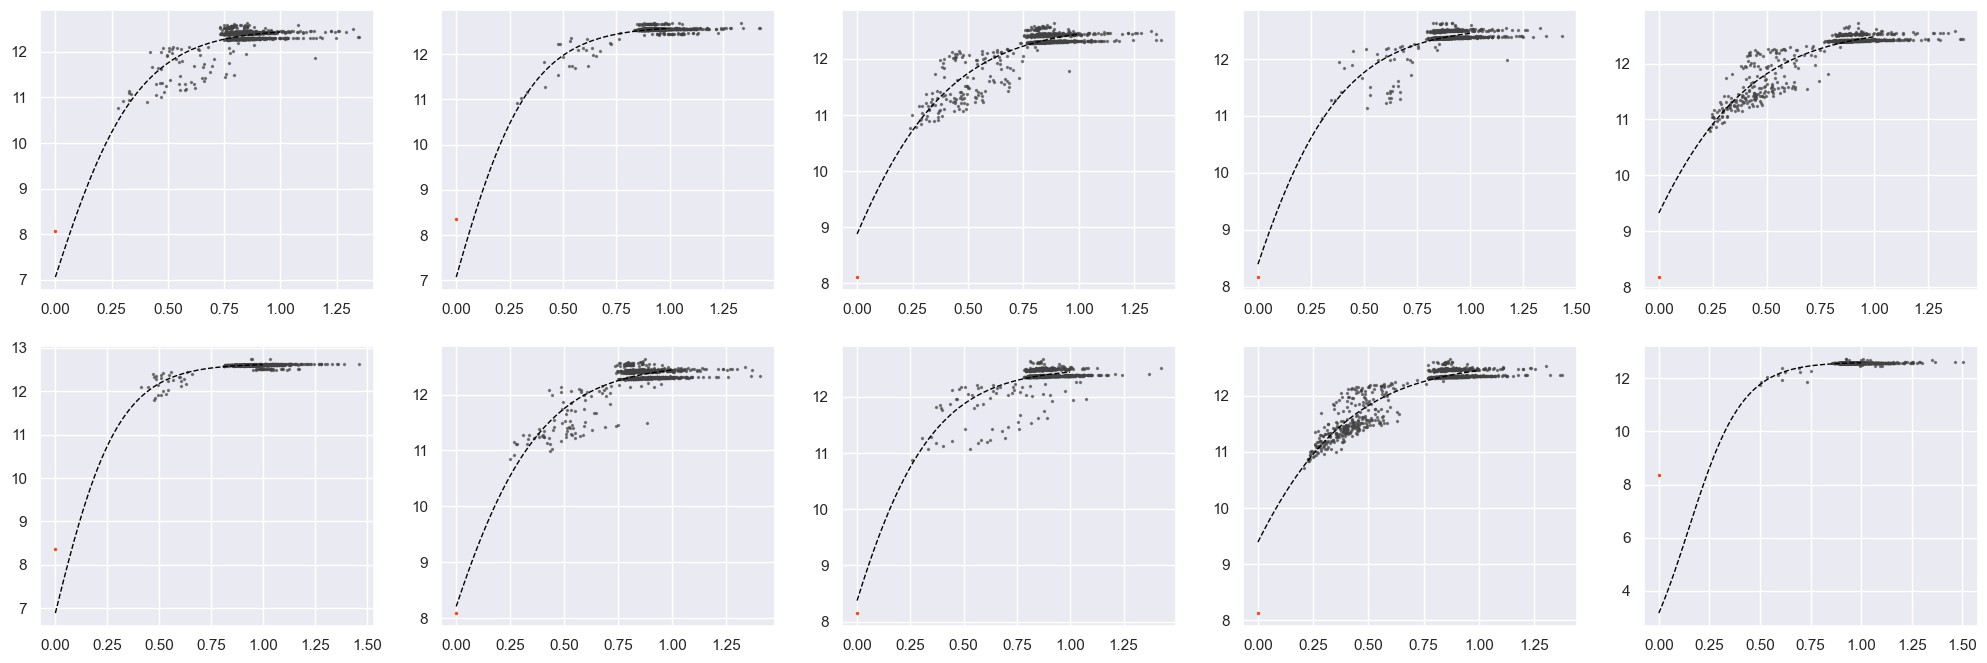

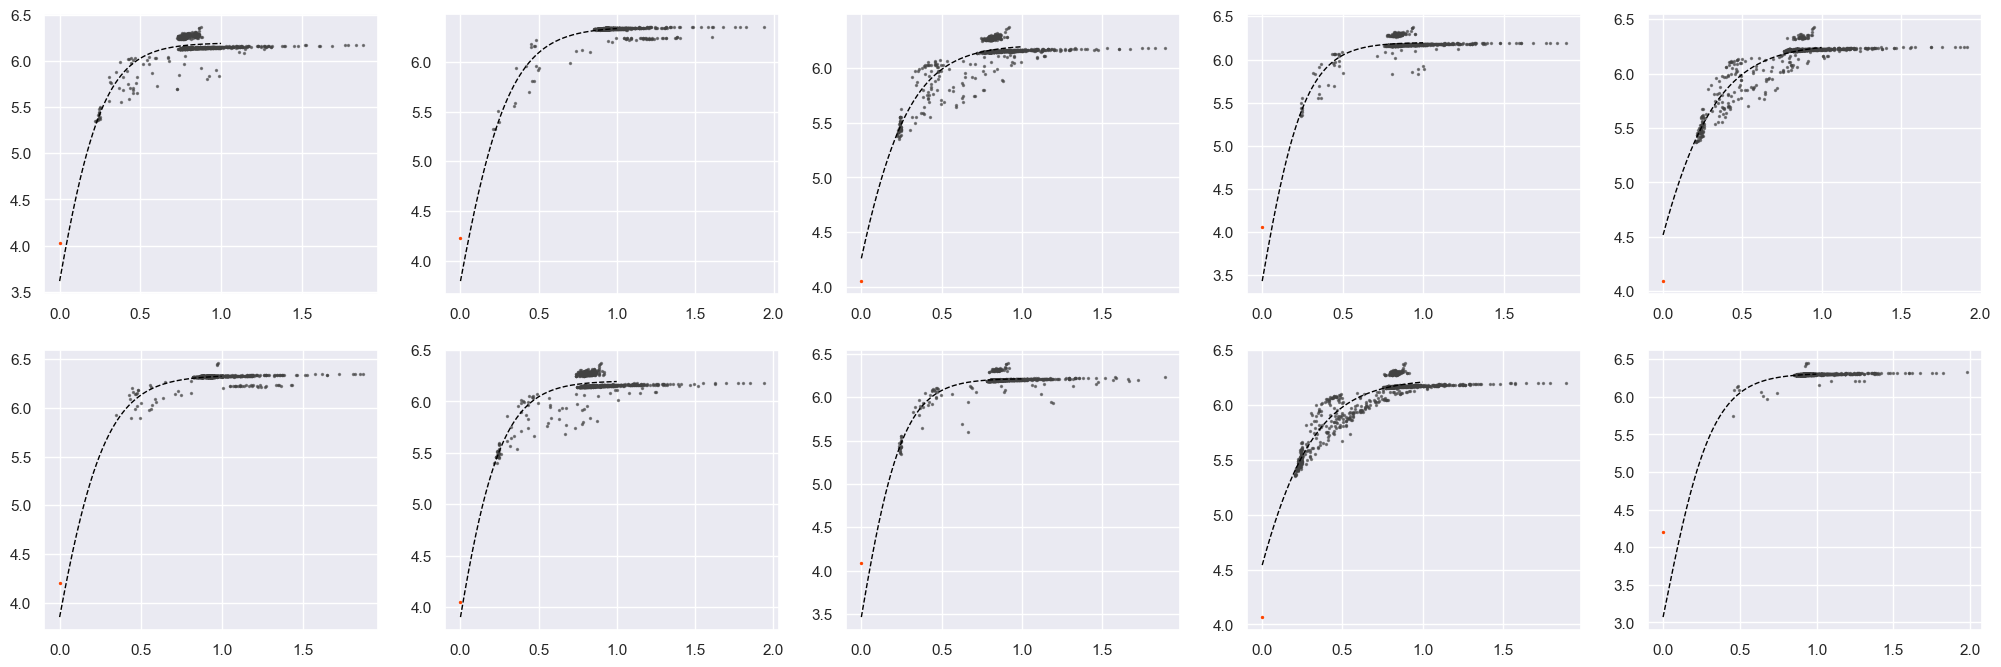

In [90]:
alpha_off = .2
alpha_on = .6

for job in ["122_native_decoys_1_state", "121_native_decoys", "155_native_N4_decoys"]:
    score_dfs = score_dfs_dict[job]

    for score_field, rmsd_field in [("xray_0+xray_1", "rmsd_0+rmsd_1"), ("xray_0", "rmsd_0")]:
        params = params_dict[job][score_field]

        fig_file = Path(Path.home(), "Desktop/score_supp_{}_{}.png".format(job, score_field))
        fig, axs = plt.subplots(2, 5, figsize=(25,8))

        for i in range(10):
            ax = axs[i//5][i%5]
            # ax.set_xlim(-.1,1.1)
            # ax.set_ylim(-.1,1.1)

            xs = score_dfs[i][rmsd_field]
            ys = score_dfs[i][score_field]

            ax = axs[i//5][i%5]
            # ax.set_xlim(-.1,x_max+.1)
            # ax.set_ylim(y_min-y_pad,y_max+y_pad)
            # ax.set_ylim(4, 7)

            ax.scatter(score_dfs[i][rmsd_field], score_dfs[i][score_field], c="#424242ff", s=2, alpha=alpha_on)
            ax.scatter(native_df.loc[i][rmsd_field], native_df.loc[i][score_field], s=2, c=colors[2])

            L_fit, k_fit, x0_fit = params[i]
            linespace = [0 + x*(1)/1000 for x in range(1000)]
            ax.plot(linespace, [logistic_func(x, L_fit, k_fit, x0_fit) for x in linespace], c="black", linewidth=1, linestyle="dashed")

        plt.savefig(fig_file)

# plt.show()

In [143]:
score_df_arr[2,1]["rmsd_0"].max()

1.1761784330056202

AttributeError: module 'matplotlib.ticker' has no attribute 'MinNLocator'

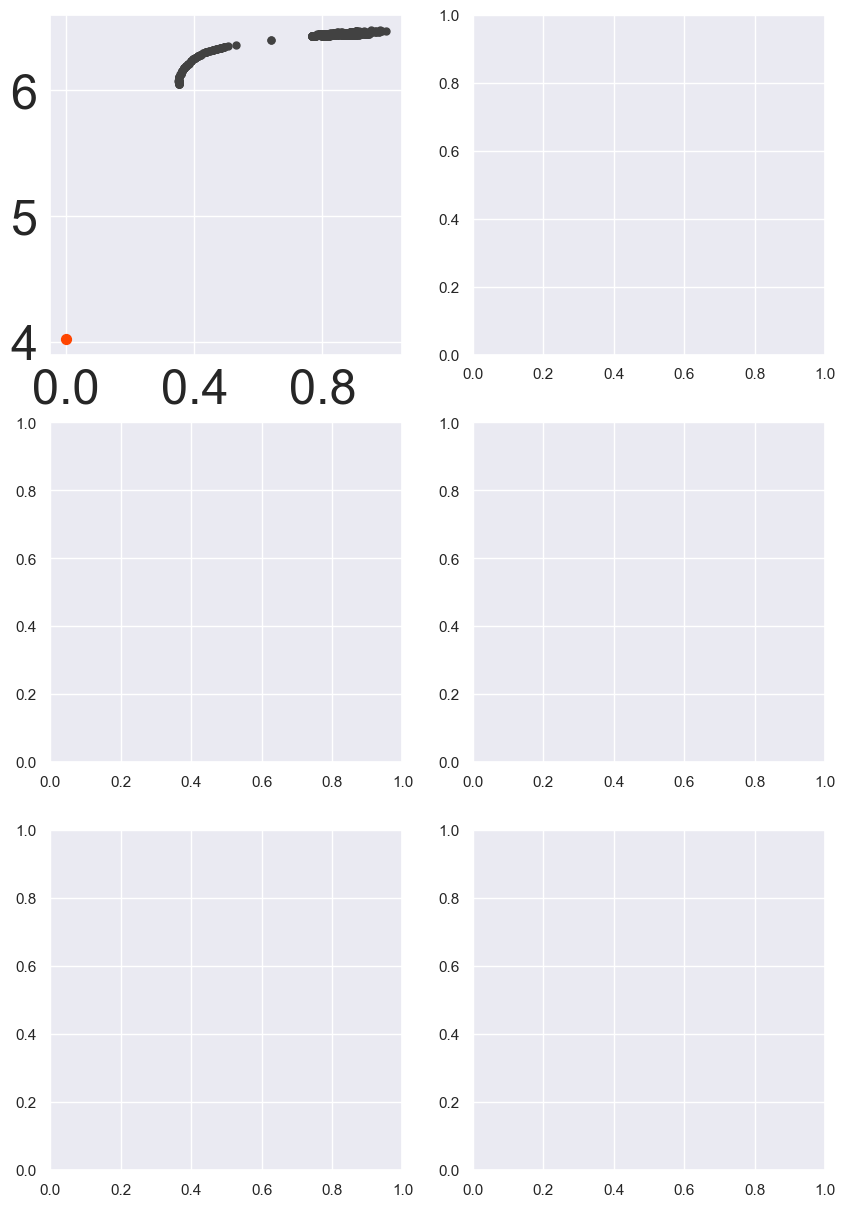

In [163]:
fig_file = Path(Path.home(), "Desktop/score_main.png".format(job, score_field))
fig, axs = plt.subplots(3, 2, figsize=(10,15))
for i in range(3):
    for j in range(2):
        score_df = score_df_arr[i,j,0]

        if j == 1:
            score_field, rmsd_field = "xray_0+xray_1", "rmsd_0+rmsd_1"
        else:
            score_field, rmsd_field = "xray_0", "rmsd_0"

        xs = score_df[rmsd_field]
        ys = score_df[score_field]

        ax = axs[i][j]
        ax.scatter(xs, ys, c="#424242ff", s=25, alpha=1)
        ax.scatter(native_df.loc[0][rmsd_field], native_df.loc[0][score_field], s=50, c=colors[2])

        ax.tick_params(axis='x', labelsize=35)
        ax.tick_params(axis='y', labelsize=35)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        L_fit, k_fit, x0_fit = params_arr[i,j,0]
        xs = [np.min(xs) + (np.max(xs)-np.min(xs))*x/1000 for x in range(1000)]
        ys = [logistic_func(x, L_fit, k_fit, x0_fit) for x in xs]
        axs[i][j].plot(xs, ys, c="black", linewidth=1, linestyle="dashed")

plt.savefig(fig_file)

# plt.show()